# Locality Sensitive Hashing for Search-by-Image Applications

Locality Sensitive Hashing is a method for reducing the dimensionality of data while preserving similarity -- either directly, by maintaining some ranking, or otherwise. Due to the pseudo-random nature of hashing functions, LSH is generally combined with a permutation or shuffle to increase the breadth of the similarities considered. 

For the purposes of this project, we produce `L` hash strings. Each is generated by extracting `k` random pixels from each image (the same pixel for each image, chosen at random prior to hash generation so that the same pixels can be used to hash a query). Each pixel considered by the hash function then appends either a 0 or 1 to the hash string generated, where a 0 indicates that the pixel's value is less than a randomly chosen threshold (chosen with the same means as the k pixels), or 1 if the pixel value is greater than or equal to that threshold.

In order for LSH to filter the dataset into qualifying candidates to be considered in the n-neighbors search, the program applies the same hash functions it applied on the dataset to the query image file. For each hash function performed, if the query hashes to the same hash-string as an image in the dataset using the same hash function, then that original image is considered in the candidate set for the n-neighbors search.

In the cells below, a brief description of the cell's contents and the reasoning as to why that cell is necessary for the LSH Search-by-Image functionality will be provided in markdown above the code cell. At the end of the notebook is an analysis of the performance metrics computed during testing (using the metrics computed at the time of submission, I cannot guarantee metrics will be the same when grading due to the randomized nature of the LSH procedure).

## Imports

The following functionalities were imported from external packages to assist with the implementations of the LSH Search-by-Image application in order to streamline the development and demonstration process. Below is a list of the imports used, as well as a brief description of why the the package was imported.

* **`os`:** The `os` package was imported for use in iterating over the filesystem in order to extract the relevant filensames and filepaths for the data files during dataset extraction.
* **`math`:** The `math` package is imported for use of its ceiling function (division where the presence of a remainder causes rounding up to the next integer). This ceiling function `ceil` is used in a later cell for displaying the image grid (since that function must work with integer values)
* **`numpy`:** This application uses `numpy.array` as the primary data structure for the data, storing the dataset as an `N` by (`H`x`W`) `numpy` array, where `N` is the number of data files, `H` is the height of the image, and `W` is the width of the image. It was preferred to use `numpy` arrays rather than a `pandas.DataFrame` due to `numpy`'s ability to efficiently reshape the image pixel vectors into the appropriate image dimensions as needed for displaying the image.
* **`matplotlib.pyplot`:** The `pyplot` class of the `matplotlib` package is used for displaying images into the output cells. Rather than saving query results in a separate folder, they are displayed into the output of the relevant cells with the use of the `matplotlib.pyplot`.
* **`time`:** From the `time` package, the `perf_counter` function was imported in order to track runtime performance of the program. One of the metrics used in comparing LSH to the classification search provided separately is the use of the perf_counter.
* **`PIL`:** From the Python Image Library package, we import the `Image` class, which is used as our primary tool for reading image data into memory and converting the pixel data into `numpy` arrays.
* **`sklearn.metrics.pairwise`:** from this package we extract the `cosine_similarity` function, which is to be used for evaluating the "similarity" score between two image pixel vectors. We chose to use cosine since it is a similarity metric rather than a distance metric. Though we could have handwritten our own cosine similarity function, we decided to use the one provided in `sklearn.metrics.pairwise` in order to improve overall readability, and likely runtime performance. We decided it would be fair to do this since the classification search would also be usilizing `sklearn`.

In [1]:
# === Imports === #
import os
import math
import numpy                  as np
import matplotlib.pyplot      as plt
from time                     import perf_counter
from PIL                      import Image
from sklearn.metrics.pairwise import cosine_similarity

# Setup: Globals and Utility Functions

The next several cells will be used for a combination of setting global variables, defining utility functions, and preparing for dataset extraction. 

## Setup: Defining Initial Globals and Updating Functions

In this cell we define the value of some of the initial globals used for computing the remaining variables needed in the setup. Such values include `L` and `k` used for LSH purposes, a `runtimes` array for logging runtime of each cell, and a `data_dir` representing the path to the root of the dataset's directory.

### Utility Function: `update_runtimes( runtimes , label , val , type )`:

We intend to use this function for managing the cataloging of runtimes for the various cells. This function will handle the under-the-hood operations of avoiding double-counting and organizing the given data into the appropriate form

**Input:** This function takes in four required parameters. `runtimes` is the current array of runtime dictinaries of the form `[{'label':label, 'val':val, 'type':type},...]` used for cataloging the runtime performance of each individual cell. The `label` parameter is the label used in the runtime dictionary that is being added/updated. The `val` parameter is the runtime for the entry being added/updated, and the `type` parameter is an integer flag used to distinguis between preprocessing (0), and querying (1). 

**Output:** A copy of the `runtimes` parameter where if an entry with the given `label` exists, the `val` and `type` values are updated witht the given parameters, otherwise, a new dictionary is appended to the `runtimes` list with the appropriate values. 

**Task:** Iterate over the given `runtimes` list. If an entry is encountered with a `label` key that matches the `label` parameter, update that entry's `val` and `type` fields to the given values (this prevents double-counting a cell's runtime if it's rerun). Finally, if no entry with such a `label` exists, construct a new dictionary of the appropriate form to be appended to the end of the list.

In [2]:
# ======================================================================
# FUNCTION: update_runtimes
# ======================================================================
# Input:
#   * runtimes: existing array of runtime dictionaries of the following form
#        [{'label':label_1, 'val':val_1, 'type':type_1}, 
#         ...,
#         {'label':label_n, 'val':val_n, 'type':type_n}]
#   * label: string representing the label key for the dictionary to be
#            added/updated
#   * val: numeric value representing the runtime (val key) of the dictionary
#          to be added/updated
#   * type: numeric (0,1) flag indicating whether the entry is a preprocessing
#           or a querying time (0=preprocessing, 1=querying)
# Output:
#   * an updated version of the runtimes array where if the label already
#     existed, its values are updated, otherwise a new entry is added with 
#     an appropriately formatted dictionary
# Task:
#   1. iterate over runtimes and test if that entry's "label" key matches
#      the given label value
#   2. If an entry exists, update its val and type keys to match the parameters
#   3. If none found during iteration, construct a dictionary of the appropriate
#      form using the given parameters, and append that dictionary to the
#      end of the list
#   4. Return the dictionary upon update or upon append
# ======================================================================
def update_runtimes( runtimes , label , val , type ):
    for i in range(len(runtimes)):
        if runtimes[i]['label'] == label:
            runtimes[i]['val']  = val
            runtimes[i]['type'] = type
            return runtimes
    runtimes.append( { 'label':label , 'val':val , 'type':type } )
    return runtimes


# === Globals Initialization === #
runtimes = list( )  # list to hold and record cell runtimes
L        = 20       # Number of hash strings to make
k        = 20       # Lenght of each hash string
data_dir = 'dataset/intel_images/full'

## Setup: Construct List of Data Directories

The following cell defines a utility function for extracting the names of the data directories, then performing such extraction into a global variable.

### Utility Function: `get_directory_list( data_dir )`:

We intend to use this function for extracting all subdirectory names in the given root data_dir file. The output resutl will be a list of these data subdirectories (each containing the data files).

**Input:** This function takes in one required parameter. `data_dir` is expected to be a string containing the root directory of the data which we will be extracting the subdirectory names of.

**Output:** A list of strings containing the subdirectory names for the given `data_dir`

**Task:** utilize the `os` package to list the contents of the `data_dir`, and return that list with the exclusion of `.DS_Store` and `README`

**Assumptions:**
1. The `data_dir` is the root directory of the data, and each subdirectory of this folder will contain the data files, no further directory branching. Data paths are `data_dir/subdir_found/image_file.jpg`
2. The only contents of `data_dir` are directores, and potentially a `.DS_Store` and a `README` (where the readme has no file type)

In [3]:
# ========================================================
# get_directory_list
# ========================================================
# Input: 
#   - data_dir: string containing absolute or relative path
#               to the root of the data files
# Output:
#   - list containing all subdirectories in the given data_dir
#     except for ".DS_Store" and "README"
# Task:
#   - Iterate over the directory list, and generate a new
#     list of the appropriate subdirectories
# ========================================================
def get_directory_list( data_dir ):
    return [ d for d in os.listdir( data_dir ) if d != '.DS_Store' and d != 'README' ]


# === Extract Directory List and Determine Time-Cost === #
t0       = perf_counter( )
dir_list = get_directory_list( data_dir )
t1       = perf_counter( )
runtimes = update_runtimes( runtimes , 'Directory List Construction' , ( t1 - t0 ) , 0 )


# === Print Results (Not Timed Since Not Necessary) === #
print( 'Directory List:\n' , dir_list )

Directory List:
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Setup: Constructing List of Data Files

The following cell defines a utility function for extracting the names of each of the data files in the dataset, then performing such extraction into a global variable.

### Utility Function: `get_file_list( data_dir , dir_list )`:

We intend to use this function for extracting all the data file names to be used from the dataset. The list of filenames will be represented in the form of their reachable path from this notebook. (Relative or Absolute pathing depends on whether `data_dir` is defined relatively or absolutely.

**Input:** This function takes in two required parameters. `data_dir` is expected to be a string containing the root directory (the path to it) of the data, and `dir_list` being a list of strings containing the names of the subdirectories where the data image files are stored.

**Output:** A list of strings containing all file names of all subdirectories in `dir_list` of the root directory `data_dir`, including file extensions.

**Task:** utilize the `os` package to list the contents of each of the `data_dir/[dir_list item]`, and return those lists concatenated into a single list

**Assumptions:**
1. The `data_dir` is the root directory of the data, and each subdirectory of this folder will contain the data files, no further directory branching. Data paths are `data_dir/subdir_found/image_file.jpg`
2. The only contents of `data_dir` are directores, and potentially a `.DS_Store` and a `README` (where the readme has no file type)
3. All files within the given `data_dir/subdir_found/` folders are workable, supported image types (.jpg, .png, etc). Note that the images do not need to be the same size, but functionality as expected in future cells cannot be guaranteed, as such cases were not tested.
4. It is assumed that the system is capable of holding the entire dataset in memory at once as a numpy array. The dataset is not reduced, and there is no provided functionality to cut the dataset if the hardware is incapable of holding it in memory. If such functionality was needed, the get_file_list would be modified to extract a random sample of the images from each of the subdirectories instead, but since that functionality was not used on development and test machines, that functionality was excluded from the program.

In [4]:
# ========================================================
# get_file_list
# ========================================================
# Input: 
#   - data_dir: string containing the path to the root directory
#               of the data files
#   - dir_list: list of data subdirectories to use
#   - sample_indices: list/array if ints denoting which pgm files
#                     to use
# Output:
#   - list containing strings. Each being the absolute/relative path
#     to the data files to be used
# Task:
#   - For each directory in the given dir_list, and for each
#     sample index in the given sample_indices, create a filepath
#     by concatenating "data_dir/directory/sample index.pgm"
# ========================================================
def get_file_list( data_dir , dir_list ):
    return [ data_dir + '/' + d + '/' + f 
             for d in dir_list 
             for f in os.listdir( data_dir + '/' + d ) ]


# === Time Construction of File List === #
t0        = perf_counter( )
file_list = get_file_list( data_dir , dir_list )
t1        = perf_counter( )
runtimes  = update_runtimes( runtimes , 'File List Construction' , ( t1 - t0 ) , 0 )


# === Print Output === #
print( 'First 10 in File List:\n' , file_list[:10] )

First 10 in File List:
 ['dataset/intel_images/full/buildings/0.jpg', 'dataset/intel_images/full/buildings/10006.jpg', 'dataset/intel_images/full/buildings/1001.jpg', 'dataset/intel_images/full/buildings/10014.jpg', 'dataset/intel_images/full/buildings/10018.jpg', 'dataset/intel_images/full/buildings/10029.jpg', 'dataset/intel_images/full/buildings/10032.jpg', 'dataset/intel_images/full/buildings/10056.jpg', 'dataset/intel_images/full/buildings/1009.jpg', 'dataset/intel_images/full/buildings/10113.jpg']


## Setup: Extracting the Shape of the Data Images

The following cell defines a utility function for extracting the height and width of the image files (based on the first image present in the file list).

### Utility Function: `get_data_dimensions( file_list )`:

We intend to use this function for extracting the height and width dimensions of the data images. The extraction is based on the first image present in the given `file_list`, and those dimensions will be applied to all images in the files in future cells.

**Input:** This function takes in one required parameter. `file_list` is expected to be a list of the data files (relative or absolute reachable paths).

**Output:** A tuple of the form `(H,W)` where `H` is the height of the first image in the list, and `W` is the list of that image.

**Task:** open the image file using `PIL.Image`, and return the `numpy.shape` of that image.

**Assumptions:**
1. The given `file_list` contains at least one data file (index 0 is valid)
2. The files listed in `file_list` contain valid file paths to existing files that are reachable from this notebook.
3. The `PIL` and `numpy` packages have been imported

In [5]:
# ========================================================
# get_data_dimensions
# ========================================================
# Input: 
#   - file_list: list of all data filepaths
# Output:
#   - Tuple containing the shape of the image, as determined by
#     numpy.shape
# Task:
#   - Open the first image in the file list, and use numpy
#     to compute it's shape
# ========================================================
def get_data_dimensions( file_list ):
    return np.shape( Image.open( file_list[0] ).convert( "L" ) )


# === Call get_data_dimensions With Appropriate Values === #
t0       = perf_counter( )
H , W    = get_data_dimensions( file_list )
t1       = perf_counter( )
runtimes = update_runtimes( runtimes , 'Dimension Extraction' , ( t1 - t0 ) , 0 )

# === Print the Output === #
print( 'Shape = %d x %d => %d Pixels' % ( H , W , H * W ) )

Shape = 150 x 150 => 22500 Pixels


## Setup: Displaying a Grid of Images

The following cell defines a utility function borrowed from Assignment 4 for displaying images in a formatted grids.

### Utility Function: `image_grid( D , H , W , cols=10 , scale=1 )`:

We intend to use this function for displaying sets/subsets of the data in the output of cells, both for final output, and for stepwise demonstration of cell functionality. 

**Input:** This function takes in three required parameters, and two optional parameters. `D` is expected to be the data matrix, where each row of `D` is the pixel-vector of a grayscale image. `H` and `W` are the respective Height and Width dimensions of the data images. For optional parameters, `cols` is the number of image columns to display in each row of the displayed image grid, and `scale` is the resizing factor (1 = fill to the full space allowed for the given number of columns).

**Output:** No Returs. This function will produce and show a `matplotlib.pyplot` figure in the output cell. The displayed images will be each of the images in the given data array `D` with appropriate dimensions, scaling, and number of columns

**Task:** Iterate over the given data array `D`, and display the grayscale image, scaled appropriately, and with the specified shape. 

**Assumptions:**
1. The given H and W are appropriate for the dimensionality of the data (HxW=length of each pixel vector)
2. The `math`, `matplotlib.pyplot`, and `numpy` packages have been imported

In [6]:
# ========================================================
# image_grid
# ========================================================
# Input: 
#   - D: array of image vectors
#   - H, W: dimensions of the image
#   - cols: number of images to show on each row
#   - scale: 1 --> fit the screen
# Output:
#   - display the given images in the specified way using
#     inline matplotlib pyplots
# Task:
#   - Iterate over each image in D, and use matplotlib.pyplot
#     to display it as specified
# ========================================================
def image_grid( D , H , W , cols=10 , scale=1 ):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n    = np.shape( D )[0]
    rows = int( math.ceil( ( n + 0.0 ) / cols ) )
    fig  = plt.figure( 1 , figsize=[ scale * 20.0/H * W , scale * 20.0/cols * rows ] , dpi=300 )
    for i in range( n ):
        plt.subplot( rows , cols , i + 1 )
        fig = plt.imshow( np.reshape( D[i,:] , [H,W] ) , cmap=plt.get_cmap( "gray" ) )
        plt.axis( 'off' )
    plt.show( )

## Setup (Final): Reading the Data into Memory

The following cell defines a utility function for extracting the image data from each of the data files, and storing the grayscale pixel vectors as rows in a numpy array. The cell then demonstrates a successful data read by displaying the first 10 images extracted using `image_grid` defined previously.

### Utility Function: `create_images_array( file_list , H , W )`:

We intend to use this function for extracting the image data from the file_list files into a pixel vector of length HxW, and appending that to a row in a numpy array. Note that the function was designed for use when the images are all the same shape. Shape mismatch shouldn't error, but may distort the image in an attempt to fit appropriately -- such conditions were not tested for use in thsi project, since our dataset was defined to be 150x150 for all images in the dataset  

**Input:** This function takes in three required parameters. `file_list` is expected to be the list of strings containing accessible paths to each of the data files to be used. `H` and `W` are the respective Height and Width dimensions of the data images.

**Output:** A numpy array of the shape (N, H\*W), where N is the number of images considered, and both H and W are the dimensions of the images. Each row contains the grayscale pixel vector of the images in the order they appear in `file_list`.

**Task:** Iterate over the given `file_list` array, extract the grayscale pixel vector, and store that vector as a row of the array. 

**Assumptions:**
1. The given H and W are appropriate for the dimensionality of the data (HxW=length of each pixel vector)
2. Each filepath specified in `file_list` is a valid file path to an existing image file supported by the Python Image Library.
2. The `PIL.Image`, and `numpy` packages have been imported prior to function use.

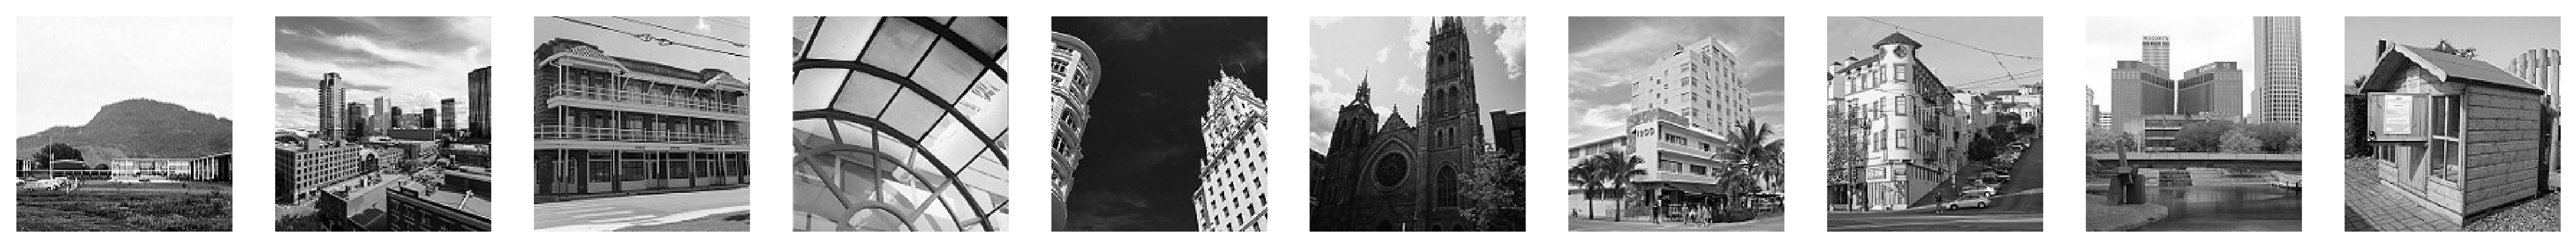

In [7]:
# ========================================================
# create_images_array
# ========================================================
# Input: 
#   - file_list: list of data filepaths to use
#   - H, W: dimensions of the image
# Output:
#   - numpy array containing the extracted image vectors for 
#     each specified image
# Task:
#   - Iterate over the given file list
#   - Open the image file
#   - Resize the image if necessary (if H,W doesn't match)
#     the image's dimensions
#   - Convert into a vecotr, and store as a row in the output
#     array
#   - return the final output array when done iterating
# ========================================================
def create_images_array( file_list , H , W ):
    im_number = len( file_list )
    arr       = np.zeros( [ im_number , H * W ] )
    for i in range( im_number ):
        im = Image.open( file_list[i] ).convert( "L" )
        if np.shape( im ) != ( H , W ):
            im = im.resize( ( W , H ) )
        arr[i,:] = np.reshape( np.asarray( im ) , [ 1 , H * W ] )
    return arr


# === Call create_images_array On file_list === #
t0       = perf_counter( )
data     = create_images_array( file_list , H , W )
t1       = perf_counter( )
runtimes = update_runtimes( runtimes , 'Data Read' , ( t1 - t0 ) , 0 )


# === Show Successful Load by Displaying First 10 in Image Grid === #
image_grid( data[:10] , H , W )

# LSH Preprocessing

The next several cells will define and perform the necessary preprocessing functionality required for Locality-Sensitive Hashing. Such functions include the definition of the `L` hash functions that produce length `k` hash strings and hashing the dataset with those functions.

## LSH Preprocessing: Defining the Hash Functions

The following cell defines two LSH Preprocessing functions used together for constructing a list of `L` randomly generated hashing functions to be used in locality-sensitive hashing. `create_single_hash_function` is expected to only be called by `create_hash_function_list` -- it is not necessary to call `create_single_hash_function` on its own (in objective programming, it would be a private function). 

### Preprocessing Function 1: `create_single_hash_function( dimensions , thresholds )`:

We intend for this function to be called once for each of the `L` hash functions generated by `create_hash_function_list`. It creates a lambda expression to perform the hashing on randomly generated parameters.

**Input:** This function takes in two required parameters. `dimensions` is expected to be a numpy array of `k` integers representing random pixels to be considered (it is assumed all values in dimensions are valid pixel locations). `thresholds` is a numpy array of `k` randomly generated value between 0 and 255 representing the flagging threshold.

**Output:** A lambda expression which, given a pixel vector `v`, will create a string of `k` bits ('1's and '0's representing the hash-string of the given vector).

**Task:** Create a lambda expression which takes an input vector `v` that will examine each of the k items in the given `dimensions` and `thresholds`, and appending either a '1' if the vector at the specified dimension is > the corresponding threshold, otherwise '0'. The final return of the lambda expression is a string of length `k` that contains only '1's and '0's. Return the created lambda expression

**Assumptions:**
1. `dimensions` contains valid indices of the pixel vectors, and `thresholds` contains values between 0 and 255.
2. Each filepath specified in `file_list` is a valid file path to an existing image file supported by the Python Image Library.

### Preprocessing Function 2: `create_hash_function_list( L , k , max_dimension , min_threshold=0 , max_threshold=255 )`

We intend this function to be the function called for generating the list of L different hash functions that produce k-bit hash strings.

**Input:** This function takes in three required parameters, and two optional parameters. `L` is an integer representing the number of hash functions to be produced, `k` represents the number of bits each hash string should be, `max_dimensions` is an integer representing the dimensionality expected of the pixel vector (no value larger will be assigned as a random pixel). For the optional parameters, `min_threshold` is the smallest possible value expected for the pixel vector (0), and `max_threshold` is the largest possible value expected for the pixel vector (255). 

**Output:** List of `L` randomly generated lambda expressions, each of which takes in a pixel vector, and outputs a length-`k` hash string of bits. 

**Task:** iterate until `L` iterations have been performed. At each iteration, produce a random `k`-length `numpy` array of the random pixels to be considered, produce a `k`-length `numpy` array of corresponding thresholds of values between `min_threshold` and `max_threshold`, and append the results of `create_single_hash_function` using the generated dimensions and thresholds arrays to a list. Once iteration completes, return the list.

**Assumptions:**
1. The range of 0-`max_dimension` is a valid range of indices for the pixel vectors
2. The `numpy` package has already been imported

In [8]:
# ========================================================
# create_single_hash_function
# ========================================================
# Input: 
#   - dimensions: k-dimensional numpy array of random pixel
#                 indices
#   - thresholds: k-dimensional numpy array of random threshold values
#                 for those pixels to be flagged
# Output:
#   - lambda expression which will hash a pixel vector into a
#     k-bit string
# Task:
#   - for each of the k items in dimensions and thresholds
#   - if the input vector for the lambda at the specified 
#     dimension is > the corresponding threshold, report '1',
#     otherwise report '0'
#   - Concate the generated list of chars into a string
#   - return the lambda expression which performs the above 
#     tasks
# ========================================================
def create_single_hash_function( dimensions , thresholds ):
    return lambda v: ''.join( 
                    [ '1' if v[ dimensions[i] ] > thresholds[i] 
                      else '0' 
                      for i in range( len( dimensions ) ) ] )


# ========================================================
# create_hash_function_list
# ========================================================
# Input: 
#   - L: number of hash functions to make
#   - k: length of each hash string
#   - max_dimension: largest valid index of the pixel vectors
#   - min_threshold=0: smallest valid value in the vectors being hashed
#   - max_threshold=255: largest valid value in the vectors being hashed
# Output:
#   - list of L different hash functions which take input vector v
#     and return a length-k string of '0's and '1'
# Task:
#   - Iterate L times:
#   - generate k random indices
#   - generate k random corresponding thresholds 
#   - Call create_single_hash_function with the generated 
#     dimensions and thresholds
#   - append the generated lambda expression to a list
#   - After generation is finished, return the list of 
#     lambda expressions
# ========================================================
def create_hash_function_list( L , k , max_dimension , min_threshold=0 , max_threshold=255 ):
    functions = list( )
    for i in range( L ):
        dimensions = np.random.randint( low=0             , high=max_dimension , size=k )
        thresholds = np.random.randint( low=min_threshold , high=max_threshold , size=k )
        functions.append( create_single_hash_function( dimensions , thresholds ) )
    return functions


# === Time the Construction of Hash Function List === #
t0             = perf_counter( )
hash_functions = create_hash_function_list( L , k , W * H )
t1             = perf_counter( )
runtimes       = update_runtimes( runtimes , 'Create Hash Functions' , ( t1 - t0 ) , 0 )


# === Output Number of Functions Created to Show Success === #
print( 'Number of Hash Functions: ' , len( hash_functions ) )

Number of Hash Functions:  20


## LSH Preprocessing: Hashing the Dataset

Rather than hashing the data at each query, the dataset need only be hashed once, then for all queries, as long as the same hashing functions are used, the dataset hash remains valid. Therefore, this is a preprocessing step that will only be performed once when the program is first run, regardless of the number of queries used (changing the hash functions will require rerunning this cell)

### Preprocessing Function: `create_hashed_data_array( L , k , data , hash_functions )`:

We intend for this function for the LSH Preprocessing step, where we perform the L different hashing functions on each of the vectors in the data array. This is a time cost of O(L\*k\*N) operation, and reduces the dimensionality of the dataset to the same size. 

**Input:** This function takes in four required parameters. `L` is the number of hash functions, `k` is the length of each hash string, `data` is the numpy array containing each pixel vector of the image data, and `hash_functions` which is the `L` length list of different hash functions created in earlier cells.

**Output:** A numpy array with `N` rows and `L` columns (where `L` is given, and `N` is the number of rows in `data`, and each cell of the array contains a length-`k` string of that vector's hash when applying the hash function with a matching column index.

**Task:** Iterate over the hash functions. Apply the hash function to each row of the data array, and update a new column of the return array with the results.

**Assumptions:**
1. `numpy` has already been imported

In [9]:
# ========================================================
# create_hashed_data_array
# ========================================================
# Input: 
#   - L: number of hash functions to make
#   - k: length of each hash string
#   - data: numpy array where each row is a pixel vector
#   - hash_functions: list of functions/lambdas which will hash
#     a given vector
# Output:
#   - new array where each row contains the L hash strings 
#     of the corresponding data row
# Task:
#   - initialize an empty numpy array of the right shape
#   - iterate over the hash functions
#   - apply the hash function to each row of the data at once
#   - update a column of the return array with the resulting 
#     hash stirngs
#   - once iteration finishes, return the array
# ========================================================
def create_hashed_data_array( L , k , data , hash_functions ):
    hashed_data = np.empty( ( len( data ) , L ) , dtype='S'+str( k ) ) # NxL array of len-k strings
    for i in range( len( hash_functions ) ):
        hashed_data[:,i] = np.apply_along_axis( hash_functions[i] , 1 , data ) # update column
    return hashed_data


# === Time to Hash the Data === #
t0          = perf_counter( )
hashed_data = create_hashed_data_array( L , k , data , hash_functions )
t1          = perf_counter( )
runtimes    = update_runtimes( runtimes , 'Hash the Dataset' , ( t1 - t0 ) , 0 )


# === Print First 2 Rows to Show Success === #
print( 'First Two Image\'s Hashes\n' , hashed_data[:2] )

First Two Image's Hashes
 [[b'11101001001011110011' b'11010001011111110011' b'11110101101100111000'
  b'00111110111011110100' b'01011001011110010010' b'00100101110111101011'
  b'01101110011111111111' b'10111010011010000110' b'01111101110110011111'
  b'11111111000111111011' b'10101101100111101111' b'10111011101111110000'
  b'11011111011111101110' b'11111110111001101110' b'00110111100100010010'
  b'11111111001100010111' b'00111101001011111111' b'01011100100111011110'
  b'11101000111011011110' b'10011111110000101101']
 [b'10101001001011100011' b'11101010011110010010' b'11100010001000011000'
  b'10110110111001100110' b'00010100011111000010' b'00100001110110101011'
  b'01100111011111110111' b'11111010010010010000' b'01011101110110011111'
  b'00101101001011111010' b'10101100100110011100' b'00100011100011010010'
  b'10000011011000100110' b'11110010001101100110' b'00010010100100010010'
  b'11111110001101010001' b'00111100100000111011' b'00110100100101011010'
  b'00101000011011001110' b'1101111

# LSH Query

Preprocessing functions are now complete. The next few cells specify functionality that is performed with each query. One demo is also performed along with the cells using an image of a snowy mountaintop (belonging to the mountain class) of appropriate dimensions (150x150) that does not exist in the full dataset.

## LSH Query: Read the Query Image into Memory

The functionality of this cell is not written as a function, since the demonstration query and label are represented differently from the multiple queries used for average metrics computation later. The `query_image_file` is the absolute or relative path to the query image, and `query_label_file` is the path to the class belonging to the query (this isn't needed for searching, but it is needed for computing the truth table when evaluating the query results). The `query_label_file` should contain a single line of text representing one of the six valid classes that the query image belongs to {"buildings", "forest", "mountain", "glacier", "sea", "street"}.

This cell uses the previously defined `create_images_array` where the `file_list` parameter is a list containing only the query image file path. The cell then reads the class label from the query label file.

Query Label: mountain
Query Image:


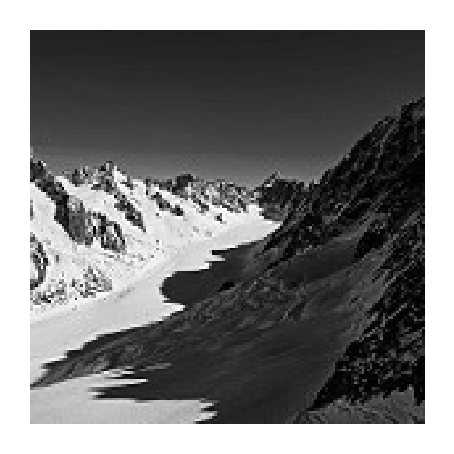

In [10]:
# === Read Into Array === #
t0               = perf_counter( )
query_image_file = 'query/demo.jpg'
query_label_file = 'query/demo.txt'
query_data       = create_images_array( [ query_image_file ] , H , W ) # get pixel data
with open( query_label_file ) as qlf: # read the Label data
    query_label = qlf.read( )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Extract Query Data' , ( t1 - t0 ) , 1 )


# === Display to Show Success === #
print( 'Query Label: {}'.format( query_label ) )
print( 'Query Image:' )
image_grid( query_data , H , W )

## LSH Query: Hash the Query Data

This cell does not define any new functions -- instead, it utilizes the previously defined `create_hashed_data_array` to perform the same hashing functions that the dataset underwent onto the query data array. This hashed query will be used for dataset filtering in order to produce a candidate set in future cells

In [11]:
# === Time to Hash the Data === #
t0         = perf_counter( )
query_hash = create_hashed_data_array( L , k , query_data , hash_functions )
t1         = perf_counter( )
runtimes   = update_runtimes( runtimes , 'Hash the Query' , ( t1 - t0 ) , 1 )


# === Print First 1 to Show Success === #
print( 'Hashed Query: ' , query_hash )

Hashed Query:  [[b'00111010010000100111' b'00001000110110110001' b'00100001011000010000'
  b'10100000001100110010' b'01000000000111000010' b'00000111100110111010'
  b'01010000001010111101' b'00111000010100000100' b'00000000000110000100'
  b'00101101000000011001' b'10001101000000001101' b'01100010110000010100'
  b'10011001001000010000' b'10000000110100100011' b'10101000100101010100'
  b'10010100000010010011' b'01001100001110100000' b'10011000001001000010'
  b'00000100001001001011' b'00011001000000000100']]


## LSH Query: Determine the Candidate Set

Now that we have both the dataset hashes and the query's hashes, we filter the dataset into its candidates by comparing hash strings. A candidate is any image file (row of the data array) which has a matching hash string with the query's hash string at the same column of the array. In other words, if the query and a datapoint "hash to the same bucket", they are likely similar (since they pass the threshold test at each of the k random representative points) -- that data point is then considered as a candidate in the n-neighbors search in later cells.

### LSH Query Function: `get_candidates( data , hashed_data , query_hash ,  file_list )`:

We intend for this function for the LSH Query step where the full dataset is reduced to a significantly smaller subset of images to be considered in the n-neighbors search. Any datapoint which hashes to the same hash string when using the same hash function is to be considered as a candidate.

**Input:** This function takes in four required parameters. `data` is the original data array of pixel vectors for the dataset, `hashed_data` is the array of hash strings for the dataset, `query_hash` the `L` different hash strings produced for the query image, and `file_list` which is a list of each of the data files in the order they appear in the data array (not necessary for candidate filtering, but is used to extract the filepaths to each of the candidates for observational purposes).

**Output:** A tuple of the form `( candidates , candidate_files )`, where `candidates` is the rows of the given `data` array which satisfy the "hash to the same bucket" condition, and `candidate_files` are the corresponding filepaths of those datapoints in `file_list`

**Task:** determine the row indices where `query_hash` and `hashed_data` share a value at any hash function, and filter the data by those candidates. If 0 candidates are found, treat the full dataset and file list as the candidate set, otherwise, filter the file list by the same indices, and return the appropriate tuple.

**Assumptions:**
1. `numpy` has already been imported
2. `hashed_data` and `query_hash` have been hashed using the same hash functions
3. `file_list` has the same number of items as `data` has rows
4. Each roe of `hashed_data` represents the hash strings of `data` for the same row.

In [12]:
# ========================================================
# get_candidates
# ========================================================
# Input: 
#   - data: array of image pixel vectors
#   - hashed_data: corresponding array of the data's hash strings
#   - query_hash: hash strings of the query with the same hash functions
#   - file_list: list of each of the data files corresponding to the rows
#                of data
# Output:
#   - tuple of the form ( candidates , candidate_files )
#        candidates = numpy array of candidate pixel vectors
#        candidate_files = the candidates' corresponding
#                          file paths
# Task:
#   - determine row indices where query_hash and hashed_data
#     share a value in any column
#   - filter the data by those indices
#   - if no candidates were found, treat the full dataset as the
#     candidate set and return (data,file_list)
#   - otherwise, filter file_list by the same indices and
#     return the filtered sets
# ========================================================
def get_candidates( data , hashed_data , query_hash , file_list ):
    candidate_indices = np.any( hashed_data==query_hash , axis=1 )
    candidates        = data[ candidate_indices ]
    if len( candidates ) == 0:
        return data , file_list
    else:
        candidate_files = [ file_list[i] 
                            for i in range( len( file_list ) ) 
                            if candidate_indices[i] ]
        return candidates , candidate_files


# === Filter the Candidate Images === #
t0                           = perf_counter( )
candidates , candidate_files = get_candidates( data , hashed_data , query_hash , file_list )
t1                           = perf_counter( )
runtimes                     = update_runtimes( runtimes , 'Filter Candidates' , ( t1 - t0 ) , 1 )


# === Show Success by Printing Number of Candidates Found === #
print( 'Number of Candidates: ' , candidates.shape[0] )

Number of Candidates:  231


## LSH Query: N-Neighbors Search

Now that we have a reduced set of candidate image files to compare, we perform a linear n-nearest-neighbors search, comparing the query to the datapoints in the candidate set. We extract the set of n-nearest neighbors to the query based on the greatest cosine similarity. If the size of the candidate set is less than the desired number of neighbors, only the candidate set will be reported, but sorted in descending order of cosine similarity to the query. Note that this is the last cell which is timed. This is because all remaining cells evaluate the performance of the n-neighbor search and LSH, as well as showing the extracted results.

### LSH Query Function: `get_n_neighbors( query_data , candidates , candidate_files ,  num_neighbors )`:

We intend for this function to extract n nearest neighbors to the query by performing a linear search on the candidate set. 

**Input:** This function takes in four required parameters. `query_data` is a numpy array containing the pixel vector of the query image, `candidates` is a filtered array of pixel vectors representing the candidate set as determined in the previous cell, `candidate_files` is the list of filepaths corresponding to the candidates given, and `num_neighbors` is the number of nearest neighbors desired.

**Output:** A tuple of the form `( neighbors , neighbor_candidates , neighbor_files )`, where `neighbors` is a list of `num_neighbors` amount of (index,cosine_similarity_to_query) tuples sorted in descending order of similarity, `neighbor_candidates` is the candidate set filtered to the `num_neighbors` nearest neighbors, and `neighbor_files` is the corresponding filepaths to those neighbors

**Task:** Compute cosine similarity between each candidate and the query, sort in descending order of similarity, slice to keep only the top `num_neighbors`, filter `candidates` and `candidate_files` by the remaining indices, and return the tuple in the appropriate form.

**Assumptions:**
1. `numpy` has already been imported
2. `candidates` has a nonzero length
3. `num_neighbors` is a positive integer

In [13]:
# ========================================================
# get_n_neighbors
# ========================================================
# Input: 
#   - query_data: array of the query's' pixel vector
#   - candidates: set of candidate pixel arrays to be searched
#   - candidate_files: list of filepaths coresponding to the candidates
#   - num_neighbors: positive int representing the number of desired 
#                    nearest neighbors
# Output:
#   - tuple of the form ( neibhors , neighbor_candidates , neighbor_files )
#        neighbors = (candiate_index,cosine_to_query) list of length num_neighbors
#                    sorted by descending cosine
#        neighbor_candidates = candidates filtered to the n-nearest neighbors in
#                              descending order
#        neighbor_files = the corresponding file paths to the neighbor images
# Task:
#   - compute cosine similarity from each candidate to the query
#   - sort by descending order of similarity
#   - filter to keep the num_neighbors most similar candidates
#   - filter candidate_files by the same indices
#   - return the tuple in the appropriate form
# ========================================================
def get_n_neighbors( query_data , candidates , candidate_files , num_neighbors ):
    # === Construct [(candidate_index,similarity)] list === #
    similarities      = np.zeros( ( len( candidates ) , 2 ) , dtype=object )
    similarities[:,0] = [ i for i in range( len( candidates ) ) ]
    similarities[:,1] = cosine_similarity( query_data , candidates )
    
    # === Sort, Slice, and Filter === #
    neighbors           = sorted( similarities , key=lambda x: x[1] , reverse=True )
    neighbors           = neighbors[ : min(num_neighbors , len( neighbors ) ) ]
    neighbor_candidates = candidates[ [ n[0] for n in neighbors ] ]
    neighbor_files      = [ candidate_files[ n[0] ] for n in neighbors ]
    
    # === Return Tuple === #
    return neighbors , neighbor_candidates , neighbor_files


# === Perform Nearest Neighbor Search and Determine Time Cost === #
t0                = perf_counter( )
num_neighbors     = 10
neighbors_results = get_n_neighbors( query_data , candidates , candidate_files , num_neighbors)
neighbors , neighbor_candidates , neighbor_files = neighbors_results
t1               = perf_counter( )
runtimes         = update_runtimes( runtimes , 'Query for N Neighbors' , ( t1 - t0 ) , 1 )


# === Display the Neighbor Set === #
print( '%d Nearest Neighbors:' % num_neighbors )
print( neighbors )

10 Nearest Neighbors:
[array([137, 0.8391487208449541], dtype=object), array([219, 0.8182472347306503], dtype=object), array([20, 0.8113377736778816], dtype=object), array([142, 0.7966393857873223], dtype=object), array([121, 0.7892168658035537], dtype=object), array([152, 0.7830285888680472], dtype=object), array([175, 0.7809741838452605], dtype=object), array([9, 0.7808021258621675], dtype=object), array([171, 0.7799420122115347], dtype=object), array([133, 0.7793824374691868], dtype=object)]


# Results and Evaluation

Note that all cells starting here are no longer timed. They are used for reporting the performance and showing the results of the prior cells, as well as a brief writeup evaluating them at the end.

## Results: Displaying Nearest Neighbor Files and Scores

This cell shows off the files of the nearest neighbors determined above, and their respective cosine similarieies to the demo query. 

### Display Function: `display_neighbors_metadata( neighbors , candidate_files )`

This function will display the nearest neighbors in order of similarity to the query, and their corresponding similarities

**Input:** This function takes in two required parameters. `neighbors` is a sorted list of tuples of the form (index, cosine to query). `neighbor_files` is a filtered array of strings containing the file paths to the neighbor's files

**Output:** No return, but a formatted print is performed to the cell's output area

**Task:** Iterate over the neighbors and candidates, and print their values in formatted order

**Assumptions:**
1. `neighbor_files` corresponds to `neighbors` with appropriate values and lengths

In [14]:
# ========================================================
# display_neighbor_metadata
# ========================================================
# Input: 
#   - neighbors: list of [(index,cosine)] tupels
#   - neighbor_files: list of filepaths to the corresponding neighbors
# Output:
#   - formatted print of the data in the two lists
# Task:
#   - iterate over the neighbor indices
#   - print the ranking of the neighber (1 is nearest)
#   - print the file of the neighbor indented
#   - print the cosine to query indented
#   - repeat for all neighbors
# ========================================================
def display_neighbors_metadata( neighbors , neighbor_files ):
    for rank in range( len( neighbors ) ):
        print( '%d:' % ( rank + 1 ) )
        print( '\tFile: \"%s\"' % neighbor_files[rank] )
        print( '\tCosine to Query: %.8f\n' % neighbors[rank][1] )
        continue
    return


# === Display the Neighbors Files and Cosines === #
print( 'Neighbors in Descending Order of Similarity:\n' )
display_neighbors_metadata( neighbors , neighbor_files )

Neighbors in Descending Order of Similarity:

1:
	File: "dataset/intel_images/full/glacier/4159.jpg"
	Cosine to Query: 0.83914872

2:
	File: "dataset/intel_images/full/street/2389.jpg"
	Cosine to Query: 0.81824723

3:
	File: "dataset/intel_images/full/buildings/3905.jpg"
	Cosine to Query: 0.81133777

4:
	File: "dataset/intel_images/full/mountain/11876.jpg"
	Cosine to Query: 0.79663939

5:
	File: "dataset/intel_images/full/glacier/10355.jpg"
	Cosine to Query: 0.78921687

6:
	File: "dataset/intel_images/full/mountain/18972.jpg"
	Cosine to Query: 0.78302859

7:
	File: "dataset/intel_images/full/sea/20099.jpg"
	Cosine to Query: 0.78097418

8:
	File: "dataset/intel_images/full/buildings/17605.jpg"
	Cosine to Query: 0.78080213

9:
	File: "dataset/intel_images/full/sea/16306.jpg"
	Cosine to Query: 0.77994201

10:
	File: "dataset/intel_images/full/glacier/23447.jpg"
	Cosine to Query: 0.77938244



## Results: Display Neighbors on Image Grid

This cell shows off the files of results of the nearest neighbor search by printing both the query image and the neighbors (in order) to show the visual similarity of the neighbors and the queyr.

### Display Function: `display_query_results_images( query_data , neighbor_candidates , H , W )`

This function will display the image grid of the query and the image grid of the neighbors in the candidate set.

**Input:** This function takes in four required parameters. `query_data` is the pixel vector of the query image. `neighbor_candidates` is the pixel vectors of the nearest neighbors from the candidate set. `H` is the height of the images, and `W` is the width of the images.

**Output:** No return, but a formatted print is performed to show the images

**Task:** call `image_grid` on both the query and neighbors with appropriate scaling and number of columns.

Query:


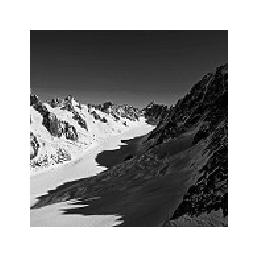

Ordered Neighbors:


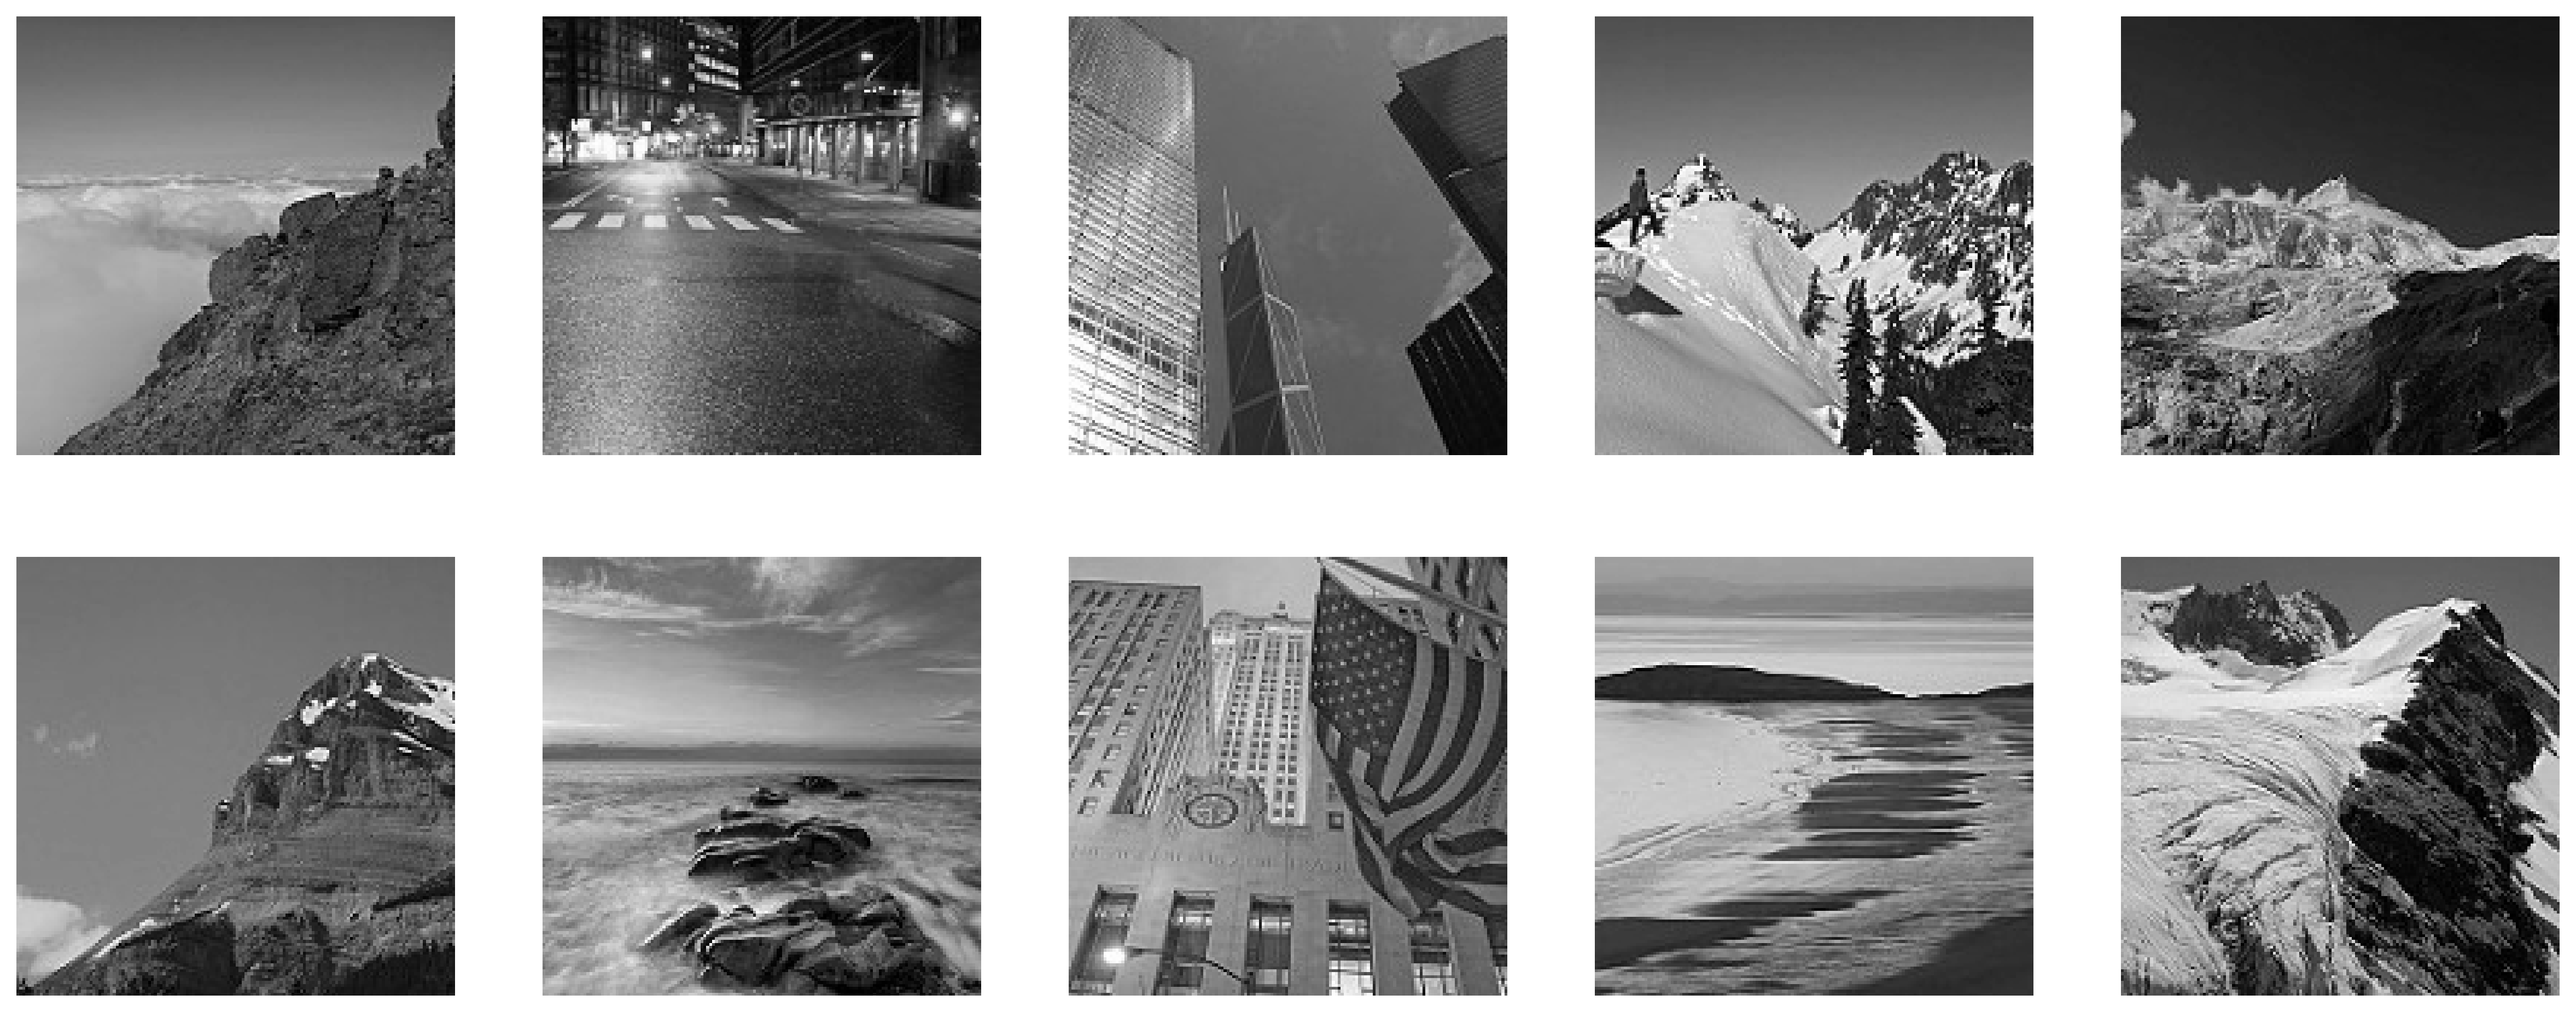

In [15]:
# ========================================================
# display_query_results_images
# ========================================================
# Input: 
#   - query_data: pixel vector of query
#   - neighbor_candidates: pixel vectors of nearest neighbors 
#                          in order
#   - H,W: dimensions of the images
# Output:
#   - formatted print of the data in the two lists
# Task:
#   - display the image grid of the query followed by 
#     the image grid of the candidates with appropriate
#     scaling and number of columns
# ========================================================
def display_query_results_images( query_data , neighbor_candidates , H , W ):
    print( 'Query:' )
    image_grid( query_data , H , W , scale=0.5 )
    print( 'Ordered Neighbors:' )
    image_grid( neighbor_candidates , H , W , cols=5 )
    return


# === Call the Above Function to Display === #
display_query_results_images( query_data , neighbor_candidates , H , W )

## Recults: N-Neighbors Class Distribution

This cell reports the class distribution of the neighbors set

### Metrics Function: `get_neighbor_classes( data_dir , neighbor_files )`

This function will compute the total number of times each class is present in the neighbors set

**Input:** This function takes in two mandatory parameters. The `data_dir` is the root directory of the data files, and the `neighbor_files` is the list of filepaths of the neighbor set

**Output:** dictionary where the keys are the class names and the values are the number of instances of that class in the neighbor set

**Task:** Iterate over the neighbor files, extract the class name from the file path, and increment that class's value in the dictionary

In [16]:
# ========================================================
# get_neighbor_classes
# ========================================================
# Input: 
#   - data_dir: root directory path of data
#   - neighbor_files: list of filepaths to the neighbor set
# Output:
#   - dictionary where key is the class and value is the
#     number of instances of that class
# Task:
#   - iterate over neighbor_files
#   - extract class name from the file path
#   - increment the appropriate class's value in the dictionary
#   - after iteration return the dictionary
# ========================================================
def get_neighbor_classes( data_dir , neighbor_files ):
    neighbor_classes = dict( )
    y                = neighbor_files.copy( )
    for i in range( len( y ) ):
        y[i]                   = y[i].replace( data_dir , '' )[ 1: ]
        y[i]                   = y[i][ :y[i].index( '/' ) ]
        neighbor_classes[y[i]] = neighbor_classes.get( y[i] , 0 ) + 1
        continue
    return neighbor_classes


# === Print the Results of the Above Computations === #
neighbor_classes = get_neighbor_classes( data_dir , neighbor_files )
print( 'Class Occurrences:' )
for nc in neighbor_classes.keys( ):
    print( '   %-10s: %d' % ( nc , neighbor_classes[nc] ) )

Class Occurrences:
   glacier   : 3
   street    : 1
   buildings : 2
   mountain  : 2
   sea       : 2


## Results: Confusion Matrix

The below cell employs the use of two functions to compute the total occurrences of truths/falses in the data/candidates, and a function for constructing a confusion matrix. The confusion matrix is defined as:
* True Positive = Image in the Candidate set shares a class with the query image
* False Positive = Image in the Candidate set with a different class than the query image
* True Negative = Image not in the candidate set with a different class than the query image
* False Negative = Image not in the candidate set which shares a class with the query image

### Metrics Function: `get_data_totals( data , candidates )`

**Input:** the function takes two required input parameters. `data` is the pixel vectors of the full dataset, and `candidates` is the pixel vectors of the candidate set

**Output:** tuple of the form `( total_files , total_positives , total_negatives )` where `total_files` is the number of files in the dataset, `total_positives` is the number of data points considered in the candidate set, and `total_negatives` is the number of datapoints not included in the candidate set

**Task:** extract the values using lengths (and potentially their complements) to determine the three metrics to be returned in the three-tuple

### Metrics Function: `get_confusion_matrix( data_dir , file_list , candidate_files , query_label )`

This function constructs a truth table where the candidate set is considered a positive and excluded files are considered negatives.

**Input:** this function takes four required input parameters. `data_dir` is the path to the root of the data directory, `file_list` is the list of all filepaths used in the dataset, `candidate_files` is the list of all files used for the candidate set, and `query_label` is the correct class of the query.

**Output:** tuple of the form `(TP, TN, FP, FN)` where `TP` is the number of true positives, `TN` is the number of true negatives, `FP` is the number of false positives, and `FN` is the number of false negatives.

**Task:** iterate over all of the filepaths, and increment the appropriate truth table value based on whether that file was a candidate and how it compares to the query's class

In [17]:
# ========================================================
# get_data_totals
# ========================================================
# Input: 
#   - data: array of the dataset's pixel vectors
#   - candidates: array of the candidate set's pixel vectors
# Output:
#   - tuple of the form (total_files, total_positives, total_negatives)
# Task:
#   - total_files = number of rows in data
#   - total_truths = number of rows in candidates
#   - total_falses = total_files - total_truths
#   - return appropriate tuple
# ========================================================
def get_data_totals( data , candidates ):
    total_files  = len( data )
    total_truths = len( candidates )
    total_falses = total_files - total_truths
    return total_files , total_truths , total_falses
    
    
# ========================================================
# get_confusion_matrix
# ========================================================
# Input: 
#   - data_dir: root directory path of data
#   - file_list: list of filepaths to the dataset
#   - candidate_files: list of filepaths to the candidate set
#   - query_label: class of the query image
# Output:
#   - dictionary where key is the class and value is the
#     number of instances of that class
# Task:
#   - iterate over the file list
#   - if the file is in the candidate_files, and same class as query:
#        increment TP
#   - if the file is in the candidate_files, and different class from query:
#        increment FP
#   - if file is not in the candidate_files, and same class as query:
#        increment FN
#   - if file is not in the candidate files, and different class from query:
#        increment TN
#   - After iteration, return appropriate tuple
# ========================================================
def get_confusion_matrix( data_dir , file_list , candidate_files , query_label ):
    TP , TN , FP , FN = 0 , 0 , 0 , 0
    for file in file_list:
        label = file
        label = label.replace( data_dir , '' )[ 1: ]
        label = label[ :label.index( '/' ) ]
        if file in candidate_files:
            if label == query_label:
                TP += 1
            else:
                FP += 1
        else:
            if label == query_label:
                FN += 1
            else:
                TN += 1
    return TP , TN , FP , FN
    
    
# === Display the Results of the get_data_totals Computation === #
total_files , total_truths , total_falses = get_data_totals( data , candidates )
print( 'Total Files:  %5d' % total_files )
print( 'Total Truths: %5d' % total_truths )
print( 'Total Falses: %5d' % total_falses )
print( '' )


# === Display the Confusion Matrix === #
TP , TN , FP , FN = get_confusion_matrix( data_dir , file_list , candidate_files , query_label )
print( 'True Positives:  %5d' % TP )
print( 'False Positives: %5d' % FP )
print( 'True Negatives:  %5d' % TN )
print( 'False Negatives: %5d' % FN )

Total Files:  17034
Total Truths:   231
Total Falses: 16803

True Positives:     23
False Positives:   208
True Negatives:  13789
False Negatives:  3014


## Results: Time Cost

Will print the time cost in a formatted way, where each cell's individual time cost is broken down and reported on its own, then the time costs are grouped by type to print, and finally, a total time is reported.

### Metrics Function: `display_time_costs( runtimes )`

**Input:** the function takes a single input parameter. `runtimes` is expected to be a list of dictionaries, each of the form `{'label':label value, 'val':time cost, 'type': 0 if preprocessing or 1 if query`.

**Output:** No return, rather, a formatted print is performed

**Task:** Iterate over the the runtimes and print with formatting, then print the totals for each type, and the overall total

In [18]:
# ========================================================
# display_time_costs
# ========================================================
# Input: 
#   - runtimes: list of dictionaries with the keys {'label','val','type'}
# Output:
#   - no return, only a formatted print
# Task:
#   - iterate over the runtimes
#   - print each iterated value
#   - print the totals
# ========================================================
def display_time_costs( runtimes ):
    # === Counters === #
    total_time      = 0
    preprocess_time = 0
    query_time      = 0
    
    # === Iteratively Print === #
    print( 'TIME COST BREAKDOWN:' )
    for runtime in runtimes:
        print( '%-27s: %2.8fs' % ( runtime['label'] , runtime['val'] ) )
        total_time += runtime['val']
        if runtime['type'] == 0:
            preprocess_time += runtime['val']
        elif runtime['type'] == 1:
            query_time += runtime['val']
        continue

    # === Print Totals === #
    print( '' )
    print( 'TOTAL TIME COSTS:' )
    print( 'Preprocessing Time (Only Needed Once): %2.8fs' % preprocess_time )
    print( 'Query Time:                            %2.8fs' % query_time )
    print( 'Total Time:                            %2.8fs' % total_time )
    return


# === Call the Above Function === #
display_time_costs( runtimes )

TIME COST BREAKDOWN:
Directory List Construction: 0.00034670s
File List Construction     : 0.01201370s
Dimension Extraction       : 0.01305060s
Data Read                  : 18.60267600s
Create Hash Functions      : 0.00197050s
Hash the Dataset           : 4.58296250s
Extract Query Data         : 0.00191260s
Hash the Query             : 0.00121720s
Filter Candidates          : 0.01879270s
Query for N Neighbors      : 0.04621870s

TOTAL TIME COSTS:
Preprocessing Time (Only Needed Once): 23.21302000s
Query Time:                            0.06814120s
Total Time:                            23.28116120s


## Results: Performance Scores Based on Confusion Matrix

In this cell we will print the results of various performance metrics that can be computed based on the confusion matrix.

### Metrics Function: `calculate_performance_metrics( TP , TN , FP , FN , metrics=None )`

**Input:** the function takes four required parameters. `TP`, `TN`, `FP`, and `FN` are the values extracted from computing the confusion matrix in earlier cells, and `metrics` is an existing metrics scores dictionary. if None is given, create from scratch, otherwise aggregate computations by adding new computations to the existing (to be averaged externally)

**Output:** dictionary where the keys are the names of the metrics and the values are the calculated scores. Keys include `{'accuracy', 'precision', 'recall', 'F1', 'MCC', 'FDR', 'TPR', 'FPR', 'TNR', 'FNR'}`

**Task:** calculate each of the metrics using their respective formulae and set or add the computation to their appropriate key. Then the dictionary is returned

In [19]:
def calculate_performance_metrics( TP , TN , FP , FN , metrics=None ):
    divide = lambda n , d: n / d if d else -1  # handle divide by zero by returning -1
    
    # === Create New if None Given === #
    if type( metrics ) == type( None ):
        metrics = dict( )
        
    # === Perform the Computations === #
    accuracy  = divide( ( TP + TN ) , ( TP + FP + TN + FN ) )
    precision = divide( TP , ( TP + FP ) )
    recall    = divide( TP , ( TP + FN ) )
    F1  = divide( ( 2 * precision * recall ) , ( precision + recall ) )
    MCC = divide( ( TP * TN - FP * FN ) , ( np.sqrt( ( TP + FP ) * ( TP + FN ) * ( TN + FP ) * ( TN + FN ) ) ) )
    FDR = divide( FP , ( FP + TP ) )
    TPR = divide( TP , ( TP + FN ) )
    FPR = divide( FP , ( FP + TN ) )
    TNR = divide( TN , ( FP + TN ) )
    FNR = divide( FN , ( TP + FN ) )
    
    # === Set the Values to Appropriate Keys === #
    metrics['accuracy']  = metrics.get( 'accuracy' , 0 ) + accuracy
    metrics['precision'] = metrics.get( 'precision' , 0 ) + precision
    metrics['recall']    = metrics.get( 'recall' , 0 ) + recall
    metrics['F1']        = metrics.get( 'F1' , 0 ) + F1
    metrics['MCC']       = metrics.get( 'MCC' , 0 ) + MCC 
    metrics['FDR']       = metrics.get( 'FDR' , 0 ) + FDR
    metrics['TPR']       = metrics.get( 'TPR' , 0 ) + TPR
    metrics['FPR']       = metrics.get( 'FPR' , 0 ) + FPR
    metrics['TNR']       = metrics.get( 'TNR' , 0 ) + TNR
    metrics['FNR']       = metrics.get( 'FNR' , 0 ) + FNR
    
    # === Return Dictionary === #
    return metrics
            
    
# === Get the Metrics from the Above Function and Print === #
metrics = calculate_performance_metrics( TP , TN , FP , FN )
print( 'METRICS FOR DEMO QUERY:' )
print( '' )
print( 'Accuracy:  %2.8f' % metrics['accuracy'] )
print( 'Precision: %2.8f' % metrics['precision'] )
print( 'Recall:    %2.8f' % metrics['recall'] )
print( 'F1:        %2.8f' % metrics['F1'] )
print( 'MCC:       %2.8f' % metrics['MCC'] )
print( 'FDR:       %2.8f' % metrics['FDR'] )
print( '' )
print( 'True Positive Rate:  %2.8f' % metrics['TPR'] )
print( 'False Positive Rate: %2.8f' % metrics['FPR'] )
print( 'True Negative Rate:  %2.8f' % metrics['TNR'] )
print( 'False Negative Rate: %2.8f' % metrics['FNR'] )

METRICS FOR DEMO QUERY:

Accuracy:  0.81084889
Precision: 0.09956710
Recall:    0.00757326
F1:        0.01407589
MCC:       -0.02411532
FDR:       0.90043290

True Positive Rate:  0.00757326
False Positive Rate: 0.01486033
True Negative Rate:  0.98513967
False Negative Rate: 0.99242674


## Computing Average Metrics Over Many Queries:

The final task to do for obtaining performance is to query over many times and take the average of the computed metrics in order to more accurately determine performance of the algorithm as a whole. A directory was created with 10 images of each class to be queried one at a time to determine more appropriate average querying metrics, the querying and metrics functions are recreated below without output, solely to achieve performance. Once performance is computed, the averages are printed with formatting. Functions defined in earlier cells are used as much as possible within this cell.

In [20]:
# === Setup: Get Query File Names and Prepare Variables for Use === #
query_dir        = 'query/batch'  # root of the query files
query_dir_list   = get_directory_list( query_dir )  # has a subdirectory for each class
query_file_list  = get_file_list( query_dir , query_dir_list )  # 10 files per subdirectory
query_metrics    = dict( )  # empty metrics dictionary
num_neighbors    = 10  # get 10 nearest neighbors
query_total_time = 0  # clear the timer


# === Query Each Query File One-at-a-Time === #
for query in query_file_list:
    
    # === Perform the Query === #
    query_start_time = perf_counter( )  # Start Timer
    
    # === Preprocessing: Get Class, Read Query Data, Hash Query === #
    query_label      = query.replace( query_dir , '' )[ 1: ]
    query_label      = query_label[:query_label.index('/')]
    query_array      = create_images_array( [query] , H , W )
    query_array_hash = create_hashed_data_array( L , k , query_array , hash_functions )
    
    # === Querying: candidate filtering, n-neighbor searching candidate set === #
    query_candidates , query_candidate_files = get_candidates( data , hashed_data , query_array_hash , file_list )
    query_neighbors , query_neighbor_candidates , query_neighbor_files = get_n_neighbors( query_array , query_candidates , query_candidate_files , num_neighbors )
    query_end_time = perf_counter()  # End Timer -- done querying
    
    # === Compute Metrics === #
    query_confusion_matrix = get_confusion_matrix( data_dir , file_list , query_candidate_files , query_label )
    query_TP , query_TN , query_FP , query_FN = query_confusion_matrix
    query_metrics = calculate_performance_metrics( query_TP , query_TN , query_FP , query_FN , query_metrics )
    query_total_time += query_end_time - query_start_time
    
    # === Iterate === #
    continue  # for query
    
    
# === Extract Number of Queries Performed === #
num_queries = len( query_file_list )


# === Formatted Print Average Metrics === #
print( 'AVERAGE METRICS FOR %d QUERIES:' % num_queries )
print( '' )
print( 'Accuracy:  %2.8f' % ( query_metrics['accuracy'] / num_queries ) )
print( 'Precision: %2.8f' % ( query_metrics['precision'] / num_queries ) )
print( 'Recall:    %2.8f' % ( query_metrics['recall'] / num_queries ) )
print( 'F1:        %2.8f' % ( query_metrics['F1'] / num_queries ) )
print( 'MCC:       %2.8f' % ( query_metrics['MCC'] / num_queries ) )
print( 'FDR:       %2.8f' % ( query_metrics['FDR'] / num_queries ) )
print( '' )
print( 'True Positive Rate:  %2.8f' % ( query_metrics['TPR'] / num_queries ) )
print( 'False Positive Rate: %2.8f' % ( query_metrics['FPR'] / num_queries ) )
print( 'True Negative Rate:  %2.8f' % ( query_metrics['TNR'] / num_queries ) )
print( 'False Negative Rate: %2.8f' % ( query_metrics['FNR'] / num_queries ) )
print( '' )
print( 'AVERAGE QUERY TIME FOR %d QUERIES:  %2.8fs' % ( num_queries , query_total_time / num_queries ) )

AVERAGE METRICS FOR 60 QUERIES:

Accuracy:  0.80929024
Precision: 0.25541338
Recall:    0.07628890
F1:        0.10819262
MCC:       0.05074977
FDR:       0.74458662

True Positive Rate:  0.07628890
False Positive Rate: 0.04420591
True Negative Rate:  0.95579409
False Negative Rate: 0.92371110

AVERAGE QUERY TIME FOR 60 QUERIES:  0.21068752s


# Objective Evaluation

Due to the randomness of the generated thresholds, the performance depended heavily on the values of L and k (number of hash functions, and the length of the hash strings). LSH attempts to greatly reduce the number of candidates by hashing the data into L different hash strings of length k. Due to the fact that querying is dependent on hashing, LSH favors rejecting data over accepting. This increases the True Negative and False Negative rates, but also reduces the True Positive and False Positive rates. When tested with L=20 and k=10, the performance was poor. Accuracy values as low as `0.07` and as high as `0.17` -- This is because the hashing was not effectively filtering the candidates (~33.33% of the dataset was candidates). When testing with L=20 and k=20, the hashing was significantly more effective at filtering the data (reducing to 90-300 candidates out of the ~17000 images). With these values, accuracy improved to approximately `0.79` to `0.82`. The majority of this accuracy improvement is due to the increase in True Negatives. 

This method is not the most effective at classifying an image, but is "decent" at correctly excluding members of different classes. Another point to consider is the similarity metric. This program uses cosine similarity on the grayscale images. This means that color filtering is not present, and the similarity rankings are solely evaluated on the brightness/light-dark values. This can result in images with similar shading to hash to the same bucked and be flagged as candidates

## Analysis of the Average Metrics Shown Above:

* **Accuracy:** the average of 60 queries showed an approximate `0.8` accuracy. This means approximately 80% of the dataset was correctly included/excluded from the candidate set. Analyzing the produced confusion matrix shows that a majority of 
* **Precision:** the average of 60 queries showed an approximate `0.24` precision. This means that a little less than 1/4 of each candidate set shared a class with the query. This is approcximately 50% better than random chance. If it was random chance, we would expect a normal distribution among the candidate set -- 6 classes = 1/6 = 0.16 of the candidates would be expected to share a class with the query otherwise
* **Recall:** the average of 60 queries showed an approximate `0.07` recall. This means that only ~7% of the correct class was present in the candidate set. Due to the large amounts of candidate exclusion, this is expected -- an extremely high number of false classifications (as long as the query shares a hash with any datapoints, otherwise, there are 0 negatives). This means that both correct and incorrect classes will be excluded at greater rates than they are included.
* **F1:** the average of 60 queries showed an approximate `0.1` F1 score. F1 is the harmonic mean between precision and recall. Low F1 in this case is not necessarily a "bad thing" since the intent of LSH is to drastically restrict the size of the candidate set. This will almost certainly reduce true positives, and increase false negatives -- both of which will reduce the F1 score. This is the cost-performance tradeoff that is made when choosing LSH (consider fewer candidates, but risk excliding more of the "right" candidates, or excluding the "best" candidates).
* **Matthews Correlation Coefficient (MCC):** the average of 60 queries showed an approximate `0.04` MCC. An MCC of approximately 0 indicates that the predictions are no better than random chance. However, this metric, like F1, must be noted with caution. Due to the filtering that is performed to generate the candidate set, the score is skewed due to the large number of reported negatives.
* **FDR:** the average of 60 queries showed an approximate `0.75` FDR score. This means that approximately 75% of the candidate set is, on average, a false positive. (note that this metric is the complement of the precision metric). This is a slightly better than chance evaluation. If the distribution was relatively normal (by chance) isntead, we would expect 5/6 (~83%) to be false positives. 
* **True Positive Rate (TPR):** the average of 60 queries showed an approximate `0.07` TPR. This score means that, on average, only 7% of all truths (data items which share a class with the query) were represented in the candidate set -- again, this is expected due to the nature of LSH and the cost-performance tradeoffs made when choosing this algorithm.
* **False Positive Rate (FPR):** the average of 60 queries showed an approximate `0.04` FPR. This score means that, on average, only 4% of all falses (data items which do not share a class with the query) -- This is the main benefit of LSH. This is one of the primary benefits of LSH. Due to the large amount of filtering that LSH performs, the proportion of falses represented in the candidate set is greatly reduced
* **True Negative Rate (NTR):** the average of 60 queries showed an approximate `0.95` TNR. This score means that, on average, 95% of all falses (data items which do not share a class witht he query) were correctly excluded from the candidate set. 
* **False Negative Rate (FNR):** the average of 60 queries showed an approximate `0.93` FNR. This score means that, on average, 93% of all truths (data items which share a class with the query) are excluded from the candidate set


## Notes on Confusion Matrix and Computation of Metrics:

* **True Positives:** We defined the "True Positive" rate/count for this project to be the number of items in the candidate set which share a class with the query (queries were manually labelled, and act as a "test set" for the data

* **False Positives:** We defined the "False Positive" rate/count for this project to be the number of items in the candidate set which do not share a class with the query.

* **True Negatives:** We defined the "True Negative" rate/count for this project to be the number of items excluded from the candidate set which do not share a class with the query

* **False Negatives:** We defined the "False Negative" rate/count for this project to be the number of items excluded from the candidate set which share a class with the query.

* **NOTE:** If the query shares no hashes with any items in the data, the entire dataset is treated as the candidate set, and the app defaults to a linear search. Because of this, it is treated as though the app produces only "positives" for that query (both true and false positives), and 0 negatives are produced. This may act as an outler for the average computation, but due to the volume of queries tested, a small number of these outliers should not have a significant impact on the metric computation.


# Subjective Evaluation

LSC did not do a good job at showing images of the same class. Often, none of the n nearest neighbors would be the same class as the query. However, all of the images shown as "nearest neighbors" were visually similar to the query. The neighbors would have similar light-dark patterns to the query. For example, when the query image `patch-593.jpg` (mountain with light lower-left and dark rest) was used, the most similar neighbors all had a light lower left and a dark rest. It would be interesting to see how performance would change with greater parameter tuning, as well as using colors -- either in the candidate search or in the candidate similarity

# Ideas for Future Improvements

1. Enable the ability to save the hashed data, so that it only needs to be one if the hash file doesn't exist, if L/k changes, or if manually told to update the hash.
2. The full dataset is currently held in memory, but is only used when hashing, and when extracting the candidates from it. It would be interesting to optimize memory usage by directly hashing the data files without extracting the 17k 150x150 images into memory, and only load the candidate files after hashes have determined the candidates. I am unsure whether this will affect query time cost, but it should reduce the memory cost from nx150x150 data values to num_candidatesx150x150. When L=20 and k=20, this is a 98-99.5% reduction in memory cost. Making the memory cost as lightweight as possible, should help improve overall performance.Also, since reading the full dataset into memory is the largest time bottleneck (approximately 16s), removing that cost should improve overall runtime, even if candidates must be read during the query.
3. Since each image file is mutually exclusive, images can be hashed in parallel, reducing the hashing time cost.
4. I would be interested in seeing if LSH can be performed on PCA to either further reduce number of comparisons per-query, or reduce the memory cost of the overall dataset.